### Optimization of Polyacrylamide MP material properties

In [6]:
from igor2.binarywave import load
import matplotlib.pyplot as plt
import numpy as np
import os 
import csv
import pandas as pd
from scipy.interpolate import interp1d
import time

#### 1. Post-processing of the Experimental Data

- The force ($F$)–displacement ($\delta$) curve obtained from the AFM device contains both loading and unloading stages. In this study, only the loading stage was used for Hertz model fitting. To do so, the portion of the curve from the point where the force begins to increase to the maximum loading point was extracted.

In [7]:
# Read experiment data
filename = "exp_data.ibw"

# Load the .ibw file
with open(filename, "rb") as f:
    data = load(f)

displ = (data['wave']['wData'][:,0]-data['wave']['wData'][0,0])*(10**6) # change the unit into um
force = data['wave']['wData'][:,1]-data['wave']['wData'][0,1]

# Find the starting/end point for the force-displacement curve
threshold = 1e-9  
min_idx = np.argmax(force > threshold) # starting point where the force starts to increase
max_idx = np.argmax(force) # end point with the maximum force 

displ_exp = displ[min_idx:max_idx]-displ[min_idx]
force_exp = force[min_idx:max_idx]-force[min_idx]

<Figure size 640x480 with 0 Axes>

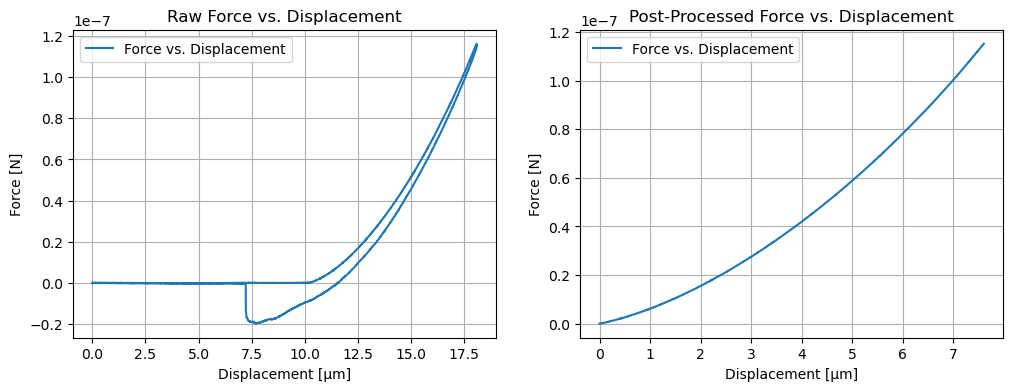

In [8]:
# Plot the raw/post-processed experiment data 
plt.figure(1)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 2 rows, 1 column

# Plot raw data
axs[0].plot(displ, force, label='Force vs. Displacement')
axs[0].set_xlabel('Displacement [μm]')
axs[0].set_ylabel('Force [N]')
axs[0].set_title('Raw Force vs. Displacement')
axs[0].legend()
axs[0].grid(True)

# Plot post-processed data
axs[1].plot(displ_exp, force_exp, label='Force vs. Displacement')
axs[1].set_xlabel('Displacement [μm]')
axs[1].set_ylabel('Force [N]')
axs[1].set_title('Post-Processed Force vs. Displacement')
axs[1].legend()
axs[1].grid(True)

#### 2. Grid Search

- In this study, two variables—Young's modulus and Poisson's ratio—were used in a grid search. For various pairs of these parameters, ABAQUS simulations were conducted, and the resulting force–displacement curves were compared with the experimental data.

- To compare the simulation and experimental results, the Root Mean Squared Error (RMSE) was used as the error metric. The simulation force–displacement curve was interpolated onto the experimental displacement points, and the RMSE was computed based on the differences between the interpolated simulation forces and the experimental forces.

- $n$: the number of experimental data points.
- $E$: Young's modulus
- $\nu$: Poisson's ratio
- $p_i(\delta_i)$: the force at the experimental displacement point $\delta_i$
- $\hat{p}_i(\hat\delta_i \, ; E, \nu)$: the force at the simulation displacement point ($\hat\delta_i$) 
- $\hat{p}_i(\delta_i \, ; E, \nu)$: the interpolated simulation force corresponding to the experimental displacement point ($\delta_i$)

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (p_i(\delta_i) - \hat{p}_i(\delta_i \, ; E, \nu))^2 }
$$

- First, the parameter boundaries and the number of grid points were defined for the simulation.

In [9]:
# Define boundaries and number of points for each variable (E and nu)
num_E_values = 41
num_nu_values = 41
E_values = np.linspace(10, 5000, num_E_values)      # Young's modulus [Pa]
nu_values = np.linspace(0.1, 0.49, num_nu_values)       # Poisson's ratio (avoid exactly 0.5)

- From the ABAQUS documentation, two parameters ($C10$ and $D$) are used to define the Neo-Hookean material model. These two parameters can be calculated from shear and bulk moduli which are also functions for Young's modulus and Poisson's ratio.

- $G$: Shear modulus, $K$: Bulk modulus  
- $C{10}$, $D$: Material parameters of Neo-Hookean model in ABAQUS

$$

G = \frac{E}{2(1+\nu)},\quad K = \frac{E}{3(1-2\nu)} \\[2em]
C10 = \frac{G}{2}, \quad D = \frac{2}{K}
$$

- For each iteration, the \( C_{10} \) and \( D \) values were calculated from Young's modulus and Poisson's ratio. To run the ABAQUS simulation with the newly calculated material properties, the material definition section in the `.inp` file (`mat_prop.inp`) was updated. This file was then merged with the main input file (`indentation.inp`) using the `*INCLUDE` function.

- The ABAQUS simulation was executed using the following command:  
  `'abaqus int job=indentation cpus=1 ask_delete=off > output.txt'`

- After the simulation, post-processing was performed using the command:  
  `'abaqus python post_processing.py'`  
  The results were then saved into a CSV file named `odb_results.csv`.

- This CSV file was loaded into the Python script, from which the force–displacement curve was extracted. The RMSE was then calculated by comparing it to the experimental curve.

In [ ]:
# Initialize RMSE grid
rmse_grid = np.zeros((len(E_values), len(nu_values)))

# Grid search
for i, E in enumerate(E_values):

    E = E*1e-6 # unit change (Pa->MPa)

    for j, nu in enumerate(nu_values):

        print(f"E = {E:.6e}, nu = {nu:.6e}")

        start_time = time.time()

        # Calculate material properties
        G  = E/2/(1+nu)
        K = E/3/(1-2*nu)
        C10 = G/2
        D1 = 2/K

        # Format the content using the variables
        file_content = f"""** 
** MATERIALS
** 
*Material, name=hyperelastic
*Hyperelastic, neo hooke
{C10}, {D1}
"""
        # Write to file
        with open("mat_prop.inp", "w") as file:
            file.write(file_content)

        # Run ABAQUS simulation
        os.system('abaqus int job=indentation cpus=1 ask_delete=off >output.txt')

        # Run ABAQUS post-processing
        os.system('abaqus python post_processing.py')

        # Extract results from the saved csv file
        results = np.loadtxt("odb_results.csv", delimiter=",", skiprows=1)

        displ_sim = -results[:,0]*(10**3)
        force_sim = results[:,1]
        expansion_sim = results[:,2]

        # Interpolate simulation force at experimental displacements
        interp_sim_force = interp1d(displ_sim, force_sim, kind='linear', bounds_error=False, fill_value='extrapolate')

        # Compute interpolated simulated force values at experimental displacement points
        force_sim_interp = interp_sim_force(displ_exp)

        # Error metrics
        abs_error = np.abs(force_sim_interp - force_exp)
        squared_error = (force_sim_interp - force_exp)**2

        # Root Mean Square Error (RMSE)
        rmse = np.sqrt(np.mean(squared_error))
        rmse_grid[i, j] = rmse

        print(f"Root Mean Square Error (RMSE): {rmse:.4e} N")

        end_time = time.time()
        print(f"Runtime: {end_time - start_time:.4f} seconds", flush=True)

E = 1.000000e-05, nu = 1.000000e-01
Runtime: 22.1978 seconds
E = 1.000000e-05, nu = 1.097500e-01
Runtime: 22.1133 seconds
E = 1.000000e-05, nu = 1.195000e-01
Runtime: 22.3708 seconds
E = 1.000000e-05, nu = 1.292500e-01
Runtime: 22.1440 seconds
E = 1.000000e-05, nu = 1.390000e-01
Runtime: 22.2354 seconds
E = 1.000000e-05, nu = 1.487500e-01
Runtime: 22.2996 seconds
E = 1.000000e-05, nu = 1.585000e-01
Runtime: 22.2529 seconds
E = 1.000000e-05, nu = 1.682500e-01
Runtime: 22.2074 seconds
E = 1.000000e-05, nu = 1.780000e-01
Runtime: 22.1954 seconds
E = 1.000000e-05, nu = 1.877500e-01
Runtime: 22.2181 seconds
E = 1.000000e-05, nu = 1.975000e-01
Runtime: 22.1476 seconds
E = 1.000000e-05, nu = 2.072500e-01
Runtime: 22.1680 seconds
E = 1.000000e-05, nu = 2.170000e-01
Runtime: 22.2354 seconds
E = 1.000000e-05, nu = 2.267500e-01
Runtime: 22.4486 seconds
E = 1.000000e-05, nu = 2.365000e-01
Runtime: 22.1124 seconds
E = 1.000000e-05, nu = 2.462500e-01
Runtime: 22.1385 seconds
E = 1.000000e-05, nu = 2

- Save into csv file (`"rmse_grid.csv"`)

In [ ]:
with open("rmse_grid.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Iteration", "E", "nu", "RMSE"])
 
    for i, E in enumerate(E_values):
        for j, nu in enumerate(nu_values):
            writer.writerow([i*num_nu_values+j+1, E, nu, rmse_grid[i, j]])

- Load csv file  (`"rmse_grid.csv"`)

In [13]:
# Load the csv file
df = pd.read_csv("rmse_grid.csv")

# Convert to numpy arrays
E_vals = df["RMSE"].groupby(df["Iteration"]).count().values
E = df["E"].unique()
nu = df["nu"].unique()
rmse_all = df["RMSE"].values

# Reshape RMSE grid
num_E = len(np.unique(df["E"]))
num_nu = len(np.unique(df["nu"]))
rmse_grid = rmse_all.reshape((num_E, num_nu))

# Scale Young's modulus to Pa
E = np.unique(df["E"].values) * 1e6
nu = np.unique(df["nu"].values)
X, Y = np.meshgrid(nu, E)

- Find the point with the minimum RMSE

In [14]:
# Find the minimum point
min_idx = np.unravel_index(np.argmin(rmse_grid), rmse_grid.shape)
min_E = E_values[min_idx[0]]
min_nu = nu_values[min_idx[1]]
min_rmse = rmse_grid[min_idx]

print(f'Young\'s modulus at the minimum RMSE : {min_E}')
print(f'Poisson\'s ratio at the minimum RMSE: {min_nu}')
print(f'Minimum RMSE: {min_rmse}')

Young's modulus at the minimum RMSE : 2380.25
Poisson's ratio at the minimum RMSE: 0.46075
Minimum RMSE: 1.18e-09


- 2D contour plot

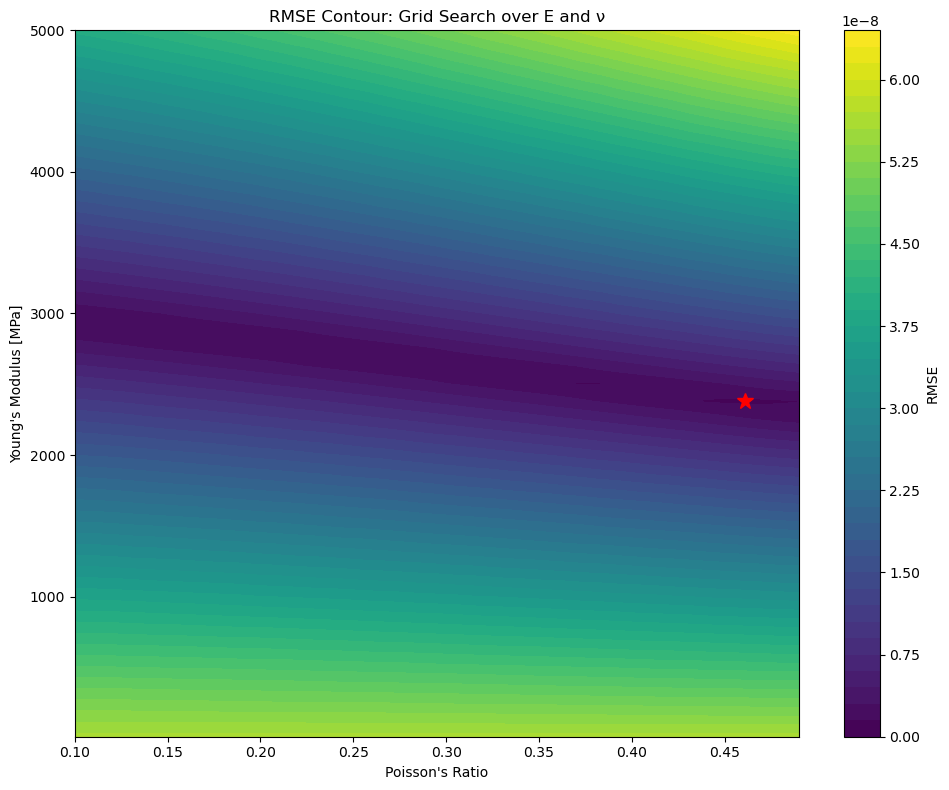

In [ ]:
plt.figure(2, figsize=(10, 8))

# Plot the contour
X, Y = np.meshgrid(nu_values, E_values)  # X: Poisson's ratio, Y: Young's modulus
cp = plt.contourf(X, Y, rmse_grid, levels=50, cmap='viridis')

# Plot the minimum point
plt.plot(min_nu, min_E, 'r*', markersize=12, label='Minimum RMSE')
plt.colorbar(cp, label='RMSE')
plt.xlabel("Poisson's Ratio")
plt.ylabel("Young's Modulus [MPa]")
plt.title("RMSE Contour: Grid Search over E and ν")
plt.tight_layout()
plt.savefig("rmse_contour.png", dpi=300)
plt.show()

- 3D surface plot

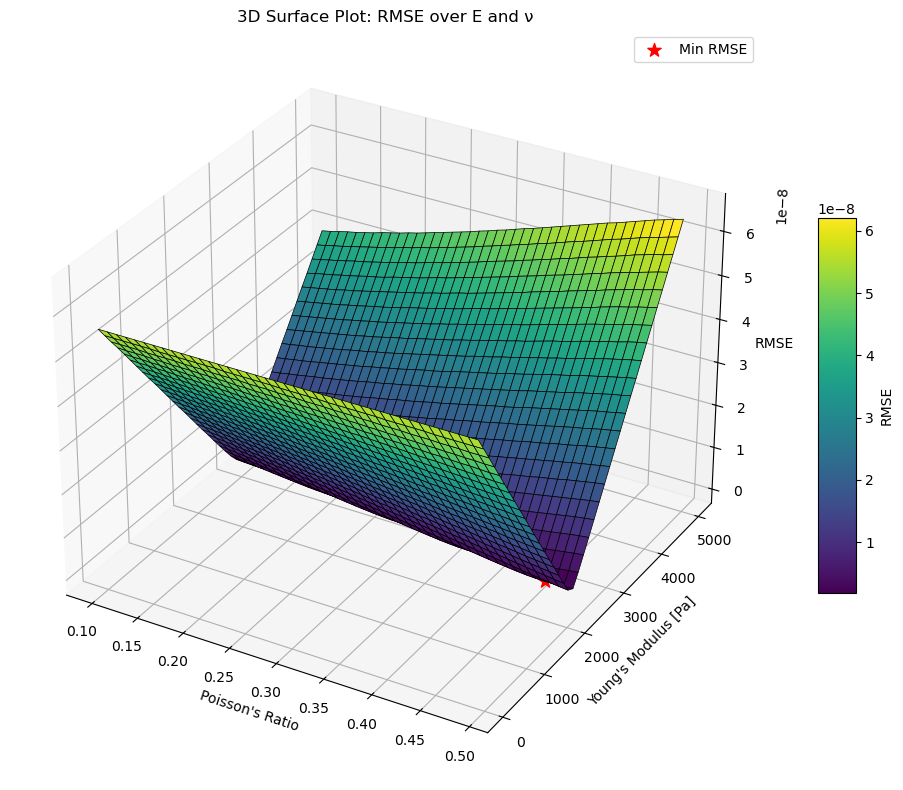

In [17]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, rmse_grid, cmap='viridis', edgecolor='k', linewidth=0.5, antialiased=True)

# Highlight minimum point
ax.scatter(min_nu, min_E, min_rmse, color='r', s=100, marker='*', label='Min RMSE')
ax.legend()

# Labels and title
ax.set_xlabel("Poisson's Ratio")
ax.set_ylabel("Young's Modulus [Pa]")
ax.set_zlabel("RMSE")
ax.set_title("3D Surface Plot: RMSE over E and ν")

fig.colorbar(surf, shrink=0.5, aspect=10, label='RMSE')

plt.tight_layout()
plt.savefig("rmse_surface.png", dpi=300)
plt.show()